## Importing the libraries

In [10]:
from PIL import Image
from io import BytesIO
import webcolors

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from importlib import reload
from mpl_toolkits import mplot3d
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from utils import *

## Settinng the logger

In [11]:
import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
sns.set(style="ticks", color_codes=True)
pd.options.display.float_format = '{:.3f}'.format

## Image Exploration

Each pixel in an image can be represented as three 8-bit unsigned (positive) integers ranging from 0 to 255, or scaled into three unsigned (positive) float ranging from 0 to 1. The three values specify the intensity values of each red, green, blue color, which often called as RGB encoding. In this notebook, we use a 220 by 220 pixels of lena.png, which serve as a standard test image widely used in image processing field.

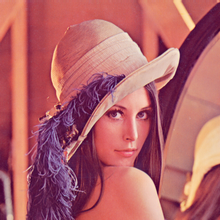

In [12]:
ori_img = Image.open('data/lena.png')
ori_img

In [13]:
X = np.array(ori_img.getdata())
ori_pixels = X.reshape(*ori_img.size, -1)
ori_pixels.shape

(220, 220, 3)

Pixels are stored as a 3D matrix with shape (220, 220, 3). The first two values specify the width and height of the image, the last value specifies the RGB encoding.

In [14]:
ori_img_size = get_image_size(ori_img)
ori_img_size

85.99609375

In [15]:
ori_img_n_colors = len(set(ori_img.getdata()))
ori_img_n_colors

37270

The original image size of lena.png is 86 KB and has 37270 unique colors present in the image.

<img src='data/variance.png'></img>

In [16]:
ori_img_total_variance = sum(np.linalg.norm(X - np.mean(X, axis = 0), axis = 1)**2)
print("Variance==> ",ori_img_total_variance)

Variance==>  302426700.6427498


## Principal Component Analysis

Principal Component Analysis or PCA is an unsupervised learning technique that is used majorly for dimensionality reduction. The process by which PCA reduces the dimensions via the following process:-

1.  It computes eigenvectors from the covariance matrix labelled as  principal axes.
2. These are sorted decreasingly by the eigenvalues called percentage of explained variance. 
3. The next step is to center the dataset and project it to the principal axes and leading to the formation of principal components.
4. For dimensionality reduction, only a certain components are considered.
5. PCA involves Singular Value Decomposition. Basically for PCA, we initially normalize the dataset and then Singular Value Decomposition.

### Process of Dimensionality Reduction
1. Assume Dataset to be 'X'
2. Normalize the dataset and center it at origin
3. The above steps cover the normalization part. The next step is to go for Singular Value Decomposition.
4. The SVD will then calculate k eigenvectors for each feature and yield a matrix V with the shape n(number of features) x k
5. The PCA projection will be Z = XV where X is the normalized and centered version of the original dataset.
6. For dimensionality reduction we take up n' < n features.


### Applying PCA for Image Compression
1. A RGB image can be considered as 3 2-D matrices overlapping each other where each matrix represents the red, green and the blue component of the image.
2. Each matrix can be considered as a dataset with the number of rows represent the number of samples and the number of columns represent the number of the features.
3. PCA can be then applied individually to each channel.


### Separating the color channels

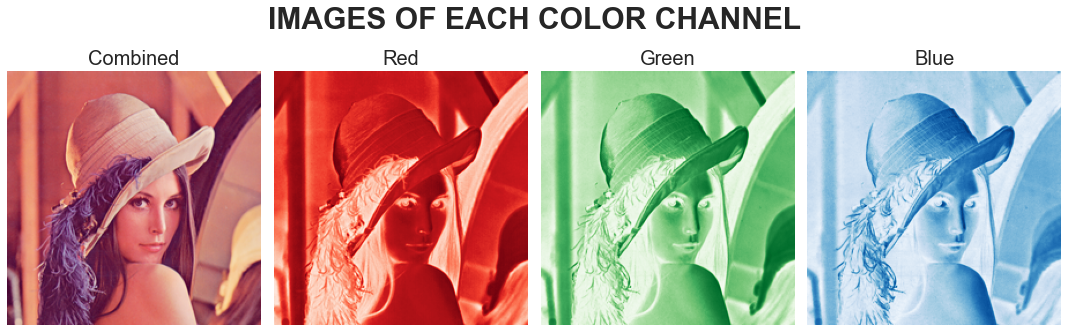

In [17]:

fig, axes = plt.subplots(1, 4, figsize=(15,5))
cmap_list = ["Reds", "Greens", "Blues"]

axes[0].imshow(ori_pixels)
axes[0].axis("off")
axes[0].set_title("Combined", size = 20)

for idx, ax, px in zip(range(3), axes[1:], ori_pixels.T):
    ax.imshow(px.T, cmap = cmap_list[idx])
    ax.axis("off")
    ax.set_title(cmap_list[idx][:-1], size = 20)
    
plt.tight_layout()
fig.suptitle("IMAGES OF EACH COLOR CHANNEL", size = 30, y = 1.03, fontweight = "bold")
plt.show()

### Principal Component Analysis for RGB Image

In [18]:
res = []
cum_var = []
X_t = np.transpose(X)
for channel in range(3):
    # SEPARATE EACH RGB CHANNEL
    pixel = X_t[channel].reshape(*ori_pixels.shape[:2])
    
    # PCA
    pca = PCA(random_state = 91)
    pixel_pca = pca.fit_transform(pixel)
    
    pca_dict = {
        "Projection": pixel_pca,
        "Components": pca.components_,
        "Mean": pca.mean_
    }
    res.append(pca_dict)
    
    # EVALUATION
    cum_var.append(np.cumsum(pca.explained_variance_ratio_))

#### Visualization of Principal Components for each channel

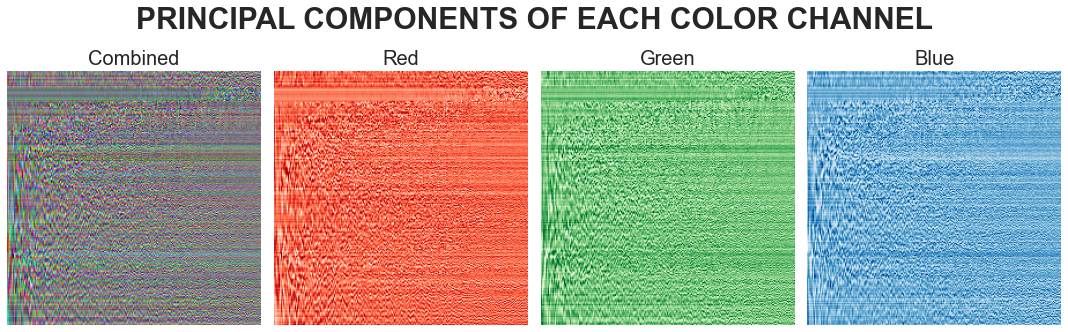

In [19]:
# Scaling the pixels
scaler = MinMaxScaler()
scaled_pixels = [scaler.fit_transform(res[i]["Components"])*255 for i in range(3)]

# Plotting the Principal Components for each Color Channel
fig, axes = plt.subplots(1, 4, figsize=(15,5))
cmap_list = ["Reds", "Greens", "Blues"]

axes[0].imshow(np.array(scaled_pixels).T/255)
axes[0].axis("off")
axes[0].set_title("Combined", size = 20)

for idx, ax, px in zip(range(3), axes[1:], scaled_pixels):
    ax.imshow((px/255).T, cmap = cmap_list[idx])
    ax.axis("off")
    ax.set_title(cmap_list[idx][:-1], size = 20)
plt.tight_layout()

fig.suptitle("PRINCIPAL COMPONENTS OF EACH COLOR CHANNEL", size = 30, y = 1.03, fontweight = "bold")
plt.show()

#### Plotting the explained variance  v/s number of components for all the color channels individually and combined.

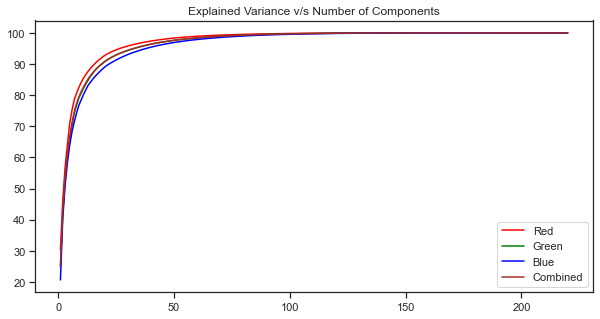

In [33]:
# Storing the variance covered in a pandas dataframe for easy plotting
cum_var_df = pd.DataFrame(np.array(cum_var).T * 100, 
                          index = range(1, pca.n_components_+1),
                          columns = ["Explained Variance by Red",
                                     "Explained Variance by Green",
                                     "Explained Variance by Blue"])
cum_var_df["Explained Variance"] = cum_var_df.mean(axis = 1)

# Plotting the variance covered
plt.figure(figsize=(10,5))
x_range = [i for i in range(1,221)]
plt.plot(x_range, cum_var_df["Explained Variance by Red"], label = "Red", color = "red")
plt.plot(x_range, cum_var_df["Explained Variance by Green"], label = "Green", color = "green")
plt.plot(x_range, cum_var_df["Explained Variance by Blue"], label = "Blue", color = "blue")
plt.plot(x_range, cum_var_df["Explained Variance"],label = "Combined",color ="brown")
plt.title('Explained Variance v/s Number of Components')
plt.legend()
plt.show()

Around 50 principal components cover almost the entire variance for all the color channels

### Generating Results

For generation of results and progessively showing the compressed images following steps are undertaken:
1. For all the number of principal components i.e. from 1 to 220 we perfrom the below written operations
2. Subset the first n columns for PCA projections and n rows of the components
3. Combine the PCA Reconstruction for all the color channels.
4. Generate the metric viz. Explained Variance, Image Size, No. Of Colors
5. Plot the compressed images with an increasing number of principal components.

In [36]:
pca_results = []
for n in range(1, pca.n_components_+1):
    # SELECT N-COMPONENTS FROM PC
    temp_res = []
    for channel in range(3):
        pca_channel = res[channel]
        pca_pixel = pca_channel["Projection"][:, :n]
        pca_comp = pca_channel["Components"][:n, :]
        pca_mean = pca_channel["Mean"]
        compressed_pixel = np.dot(pca_pixel, pca_comp) + pca_mean
        temp_res.append(compressed_pixel.T)
    compressed_image = np.transpose(temp_res)
    
    pca_dict = {
        "n": n,
        "Pixels": compressed_image,
        "Explained Variance": cum_var_df["Explained Variance"][n],
        "Image Size (KB)": get_image_size(compressed_image),
        "No. of Colors": len(np.unique(np.uint8(compressed_image).reshape(-1, 3), axis = 0))
    }
    
    pca_results.append(pca_dict)

pca_results = pd.DataFrame(pca_results).set_index("n")
pca_results.head()

Pixels  Explained Variance  \
n                                                                          
1  [[[197.04434252288166, 74.80874312804775, 81.2...              25.281   
2  [[[202.6969308349154, 75.77550819768378, 80.36...              42.780   
3  [[[199.95026207316485, 85.94707173824669, 87.6...              53.309   
4  [[[199.0977466454184, 83.85824159985992, 87.07...              60.781   
5  [[[208.18535152029898, 91.19498360910242, 87.3...              66.744   

   Image Size (KB)  No. of Colors  
n                                  
1           34.700          30476  
2           43.257          39829  
3           47.349          41167  
4           50.664          42047  
5           53.288          42426

#### Plotting the metrics v/s number of principal components

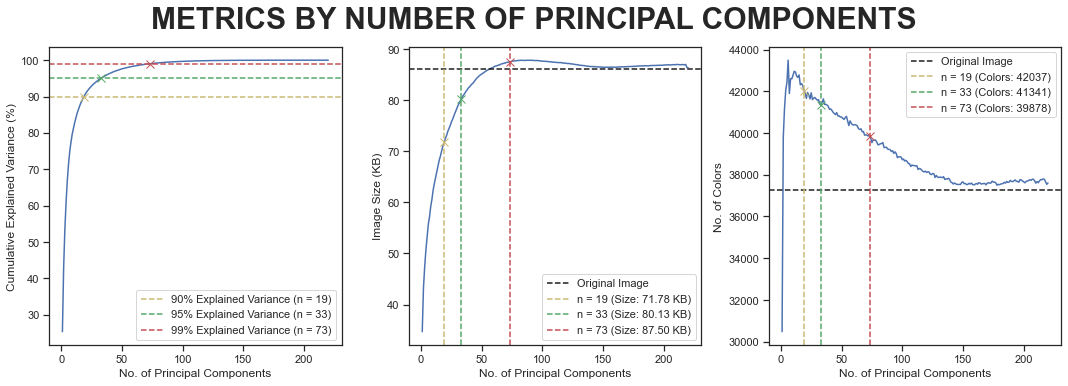

In [37]:
line_colors = "ygr"
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, metric in zip(axes, pca_results.columns[1:]):
    sns.lineplot(x = pca_results.index, y = metric, data = pca_results, ax = ax)
    ax.set_xlabel("No. of Principal Components")
    
    if metric == "Explained Variance":
        lookup_n_var = []
        for idx, exp_var in enumerate([90, 95, 99]):
            lookup_n = pca_results[pca_results[metric] >= exp_var].index[0]
            lookup_n_var.append(lookup_n)
            ax.axhline(y = exp_var, color = line_colors[idx], linestyle = '--',
                       label = "{}% Explained Variance (n = {})".format(exp_var, lookup_n))
            ax.plot(lookup_n, exp_var, color = line_colors[idx], marker = 'x', markersize = 8)
            ax.set_ylabel("Cumulative Explained Variance (%)")
        ax.legend()
        continue
    elif metric == "Image Size (KB)":
        y_val = ori_img_size
        line_label = "n = {} (Size: {:.2f} KB)"
    elif metric == "No. of Colors":
        y_val = ori_img_n_colors
        line_label = "n = {} (Colors: {})"
        
    ax.axhline(y = y_val, color = 'k', linestyle = '--', label = "Original Image")
    for idx, n_components in enumerate(lookup_n_var):
        lookup_value = pca_results.loc[n_components, metric]
        ax.axvline(x = n_components, color = line_colors[idx], linestyle = '--',
                   label = line_label.format(n_components, lookup_value))
        ax.plot(n_components, lookup_value, color = line_colors[idx], marker = 'x', markersize = 8)
    ax.legend()
plt.tight_layout()
fig.suptitle("METRICS BY NUMBER OF PRINCIPAL COMPONENTS", size = 30, y = 1.07, fontweight = "bold")
plt.show()

#### Plotting the Compressed(Reconstructed) Images for various number of components

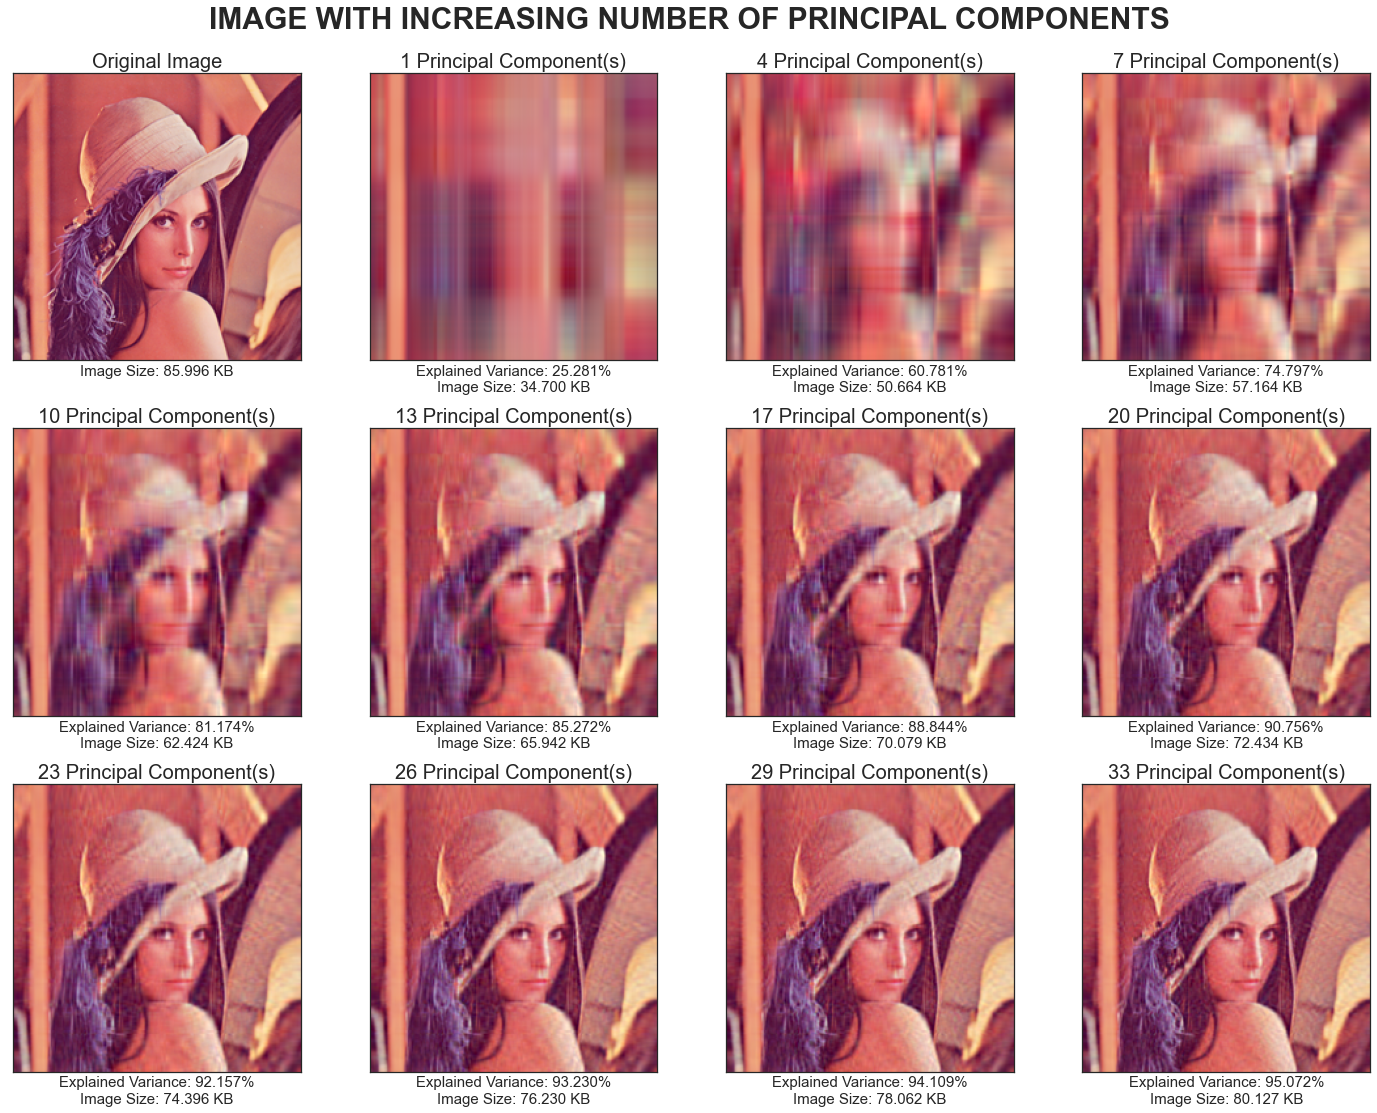

In [38]:
n_pca_images = (3, 4)
end_pc = pca_results[pca_results["Explained Variance"] >= 95].index[0]

fig, axes = plt.subplots(*n_pca_images, figsize=(20,15))
plot_n = np.linspace(1, end_pc, n_pca_images[0]*n_pca_images[1]-1, endpoint = True, dtype = int) 

# PLOTTING ORIGINAL IMAGE
axes[0][0].imshow(X.reshape(*ori_img.size, 3))
axes[0][0].set_title("Original Image", fontsize = 20)
axes[0][0].set_xlabel("Image Size: {:.3f} KB".format(ori_img_size), fontsize = 15)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
        
for ax, n in zip(axes.flat[1:], plot_n):
    # PLOTTING COMPRESSED IMAGE
    ax.imshow(pca_results.loc[n, "Pixels"]/255)
    ax.set_title("{} Principal Component(s)".format(n), fontsize = 20)
    ax.set_xlabel("Explained Variance: {:.3f}%\nImage Size: {:.3f} KB".format(pca_results.loc[n, "Explained Variance"],
                                                                            pca_results.loc[n, "Image Size (KB)"]),
                  fontsize = 15)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.suptitle("IMAGE WITH INCREASING NUMBER OF PRINCIPAL COMPONENTS", size = 30, y = 1.03, fontweight = "bold")
plt.show()

From the plots, **33 Principal Components** are the ideal choice because at this value reasonably high variance is covered and the number of colors are almost same as the original image.

In [39]:
target_exp_var = 95
n_opt = pca_results[pca_results["Explained Variance"] >= target_exp_var].index[0]
n_opt

33

#### Comparision with original image

In [41]:
ori = {
    "Type": "Original",
    "Pixels": X,
    "No. of Colors": ori_img_n_colors,
    "Image Size (KB)": ori_img_size,
    "Explained Variance": 100
}

pc_reduced = {
    "Type": "PC-Reduced",
    "Pixels": pca_results.loc[n_opt, "Pixels"],
    "No. of Colors": pca_results.loc[n_opt, "No. of Colors"],
    "Image Size (KB)": pca_results.loc[n_opt, "Image Size (KB)"],
    "Explained Variance": pca_results.loc[n_opt, "Explained Variance"]
}
ori_vs_pca = pd.DataFrame([ori, pc_reduced]).set_index("Type")
ori_vs_pca

Pixels  No. of Colors  \
Type                                                                           
Original    [[225, 137, 127], [224, 137, 127], [227, 134, ...          37270   
PC-Reduced  [[[207.89438005428536, 120.16192265294717, 109...          41341   

            Image Size (KB)  Explained Variance  
Type                                             
Original             85.996             100.000  
PC-Reduced           80.127              95.072

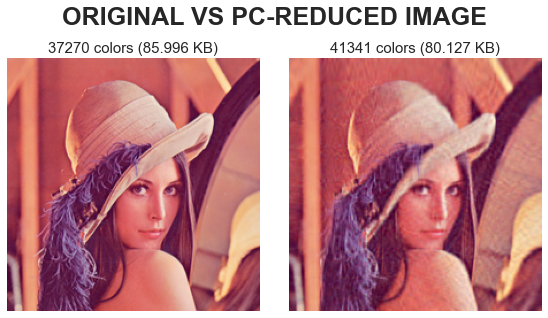

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
for ax, (typ, row) in zip(axes.flat, ori_vs_pca.iterrows()):
    img_array = np.array(row["Pixels"]/255)
    ax.imshow(img_array.reshape(*ori_img.size, 3))
    ax.axis("off")
    ax.set_title("{} colors ({:.3f} KB)".format(row["No. of Colors"], row["Image Size (KB)"]), fontsize=15)
plt.tight_layout()
fig.suptitle("ORIGINAL VS PC-REDUCED IMAGE", size = 25, y = 1.1, fontweight = "bold")
plt.show()

In [47]:
relative_size = ori_vs_pca.loc["PC-Reduced", "Image Size (KB)"]/ori.get("Image Size (KB)")
print("Reduction: {:.3f}% from original image size".format((1-relative_size)*100))
print("Explained Variance: {:.3f}%".format(ori_vs_pca.loc["PC-Reduced", "Explained Variance"]))

Reduction: 6.825% from original image size
Explained Variance: 95.072%


Thus with the help of Principal Component Analysis we have achieved a 6.9% size reduction while covering reasonable variance and using the similar number of colors as the original image